<a href="https://colab.research.google.com/github/lapshinaaa/homework_machineLearning/blob/main/hw06_texts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data 


Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [1]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from string import punctuation
import warnings
warnings.filterwarnings('ignore')

In [2]:
# unnecessary code lines since I directly downloaded the file 'train.csv'
#!pip install kaggle

#from google.colab import files
#files.upload()

#!mkdir -p ~/.kaggle
#!cp kaggle.json ~/.kaggle/

In [3]:
data = pd.read_csv('train.csv')

In [4]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [6]:
from sklearn.impute import SimpleImputer
# checking for missing values:
train.isnull().values.any() # output: True --> found missing values

True

In [7]:
test.isnull().values.any() # output: True --> found missing values

True

In [8]:
# filling in the blanks with empty strings:
train = train.fillna('')
test = test.fillna('')
train.isnull().values.any() # output: False --> no missing values found
test.isnull().values.any()  # output: False --> no missing values found

False

## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?


In [9]:
# getting the target variable
y_train = train['target']

# checking the balance of classes:
print('Balance of classes:')
print(y_train.value_counts())

Balance of classes:
0    3024
1    2305
Name: target, dtype: int64


2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [10]:
# getting the most popular keywords as a list:
# taking 11 most popular, and then cutting the first one since it's an empty string
popular_keywords = train['keyword'].value_counts().sort_values()[::-1][:11][1:]
popular_keywords

damage               36
siren                35
wreckage             34
fatalities           33
deluge               31
emergency            30
harm                 30
twister              30
nuclear%20reactor    30
fatality             30
Name: keyword, dtype: int64

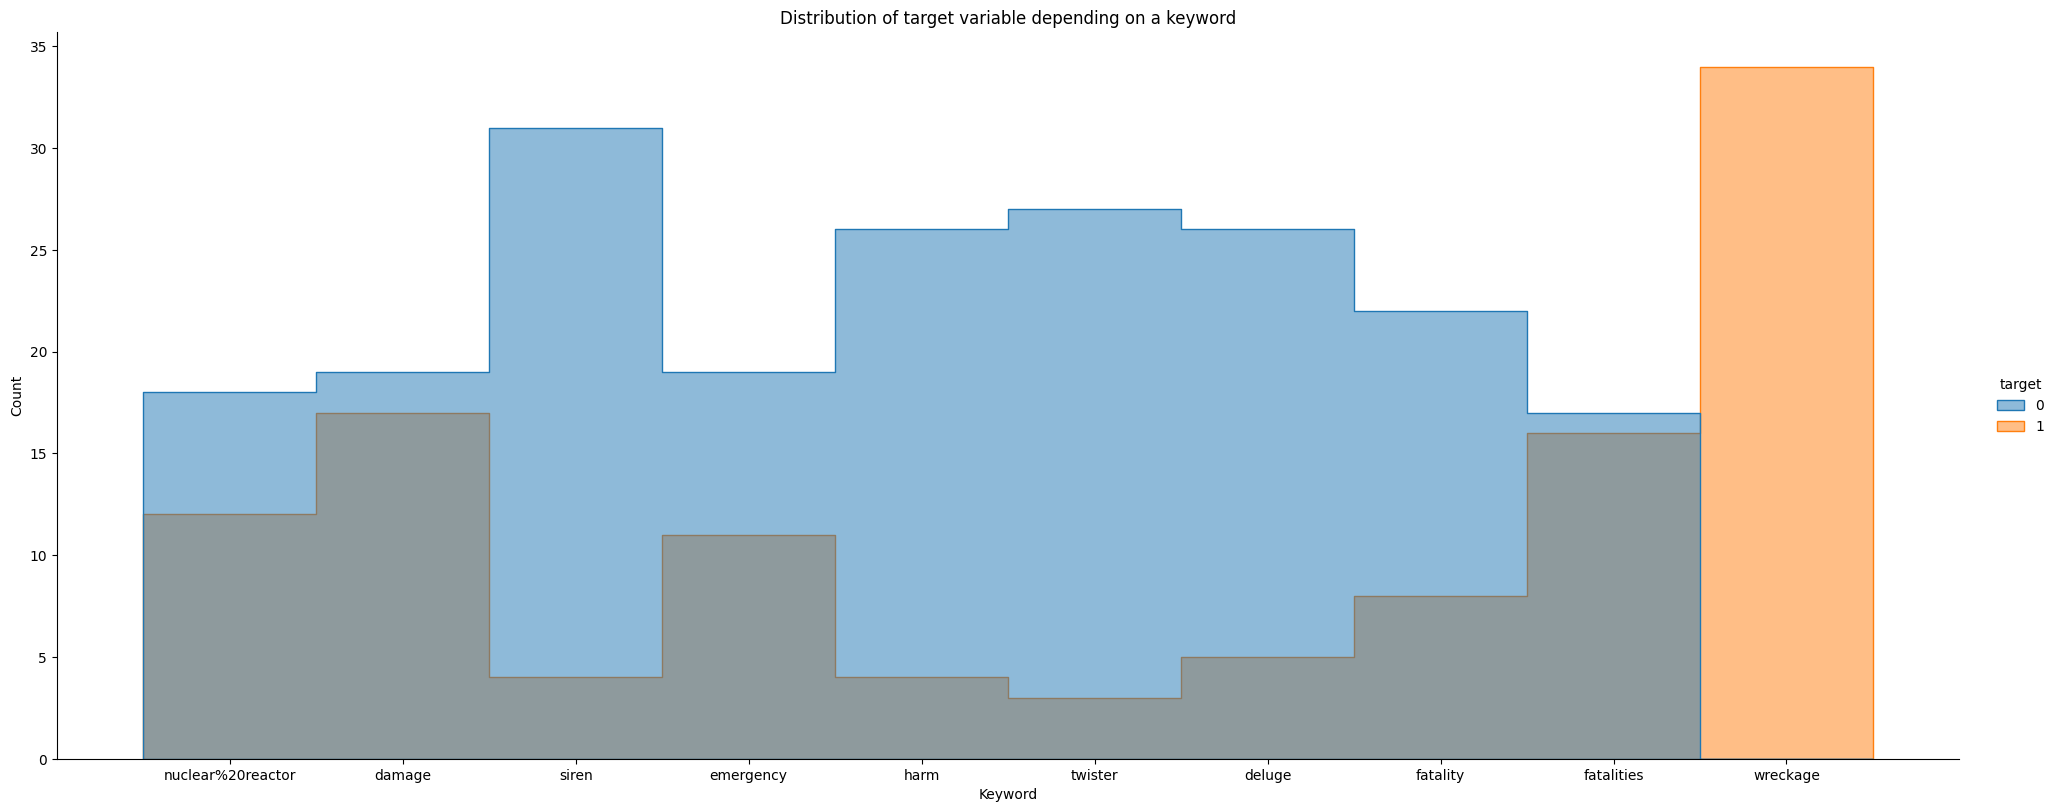

In [11]:
# Choosing only 'keyword' and 'target' columns for a new dataframe
df = train[['keyword', 'target']]
popular_keywords = df['keyword'].value_counts().sort_values()[::-1][:11][1:].index.tolist() 
df = df[df['keyword'].isin(popular_keywords)]

# plotting the distribution
sns.displot(data=df, x='keyword', hue='target', element='step', alpha=0.5, height=8, aspect=2.5)

plt.xlabel('Keyword')
plt.ylabel('Count')
plt.title('Distribution of target variable depending on a keyword')

# showing the plot
plt.show()

**Выводы**: анализируя график распределения классов, можем сделать вывод о том, что такие ключевые слова, как "wreckage", "fatalities", "damage" часто говорят о наличии информации о настоящей катастрофе/инциденте в твите. В то же время, "twister", "siren", "harm", напротив, содержатся чаще всего в твитах, не содержащих информации о катастрофе.

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [12]:
train.loc[[6590, 7122, 2769]]

,id,keyword,location,text,target
6590,9436,survivors,"Marietta, GA",Stemming from my #Cubs talk- the team rosters ...,1
7122,10203,violent%20storm,,If you were the NWS wth a rotating storm w/ a ...,1
2769,3980,devastation,Atlanta g.a.,http://t.co/Gxgm1T3W0J From Devastation to Ela...,0


In [13]:
# concatenating 'keyword', 'location', and 'text' columns
train['text'] = train.apply(lambda x: ' '.join(x[['keyword', 'location', 'text']].astype(str)), axis=1)

# dropping all the unnecessary columns
train_new = train.drop(columns=['id', 'keyword', 'location'], axis=1, inplace=False)

In [14]:
train_new.loc[[6590, 7122, 2769]]

,text,target
6590,"survivors Marietta, GA Stemming from my #Cubs ...",1
7122,violent%20storm If you were the NWS wth a rot...,1
2769,devastation Atlanta g.a. http://t.co/Gxgm1T3W0...,0


## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [15]:
from sklearn.feature_extraction.text import CountVectorizer

# creating an instance of vectorizer and getting the matrix
cnt_vec = CountVectorizer()
X = cnt_vec.fit_transform(train_new['text'])
X.toarray()

# creating a dataframe to illustrate the results
pd.DataFrame(X.toarray(), columns=cnt_vec.get_feature_names_out())

,00,000,0000,00cy9vxeff,00end,00pm,01,011072,014213,02,...,ûïthe,ûïwe,ûïwhen,ûïyou,ûò,ûò800000,ûó,ûóher,ûókody,ûótech
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5324,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5325,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5326,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5327,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [16]:
from string import punctuation

def contains_digit(s: str) -> bool:
    # checking if the word contains any digits (True if it does, False - otherwise)
    return any(char.isdigit() for char in s)

def contains_punctuation(s: str) -> bool:
    # checking if the word contains any punctuation signs
    return any(char in punctuation for char in s)

def is_hashtag(s: str) -> bool:
    # checking of the word is a hashtag
    return s[0] == "#"

def is_mention(s: str) -> bool:
    # checking if the word is a mention
    return s[0] == "@"

def investigate_vocabulary(vocabulary):
    # initializing counters for words of each category
    count_digit = 0
    count_punctuation = 0
    count_hash = 0
    count_mention = 0

    # iterating over the keys and checking each word
    for word in vocabulary.keys():
      if contains_digit(word): count_digit += 1
      if contains_punctuation(word): count_punctuation += 1
      if is_hashtag(word): count_hash += 1
      if is_mention(word): count_mention += 1

    print('With digit:      ', count_digit
          )
    print('With punctuation:', count_punctuation
          )
    print('Hashtags:        ', count_hash
          )
    print('Mentions:        ', count_mention
          )

In [17]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)

With digit:       2
With punctuation: 7
Hashtags:         1
Mentions:         3


In [18]:
# getting vocabulary first:
vocab_dict = cnt_vec.vocabulary_

# passing the vocab to the function
investigate_vocabulary(vocab_dict)

# Выводы: результаты довольно интересные. Не нашлось ни одного слова-упоминания 
# и ни одного хештега.

With digit:       3812
With punctuation: 315
Hashtags:         0
Mentions:         0


## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [19]:
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer()

# applying CountVectorizer with a tweet tokenizer 
cnt_vec_tweet = CountVectorizer(tokenizer=tweet_tokenizer.tokenize)

In [20]:
# creating a new matrix and illustrating the results:
X = cnt_vec_tweet.fit_transform(train_new['text'])
X.toarray()
pd.DataFrame(X.toarray(), columns=cnt_vec_tweet.get_feature_names_out())

,!,#,##youtube,#034,#039,#06,#09,#1-1st,#1008pla,#140,...,ûïthe,ûïwe,ûïwhen,ûïyou,ûò,ûò800000,ûó,ûóher,ûókody,ûótech
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5324,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5325,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5326,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5327,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# getting vocabulary first:
vocab_dict = cnt_vec_tweet.vocabulary_

investigate_vocabulary(vocab_dict
                       )

With digit:       3939
With punctuation: 7338
Hashtags:         1470
Mentions:         1679


**Сравнение:** Как видно из результатов, при использовании CountVectorizer без указания токенизатора, он использует свой встроенный токенизатор, разбивающий текст на токены таким образом, что хештеги (#) и упоминания (@) не учитываются. Использование же TweetTokenizer позволяет учесть наличие упоминаний, хештегов и других специальных символов (в качестве отдельных токенов), что, безусловно, может оказаться очень полезным при анализе твитов и других текстов социальных сетей.

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer



In [22]:
from nltk.text import TokenSearcher
from os import remove
import re
from nltk.stem.snowball import SnowballStemmer
import nltk
nltk.download("stopwords", quiet=True)
from nltk.corpus import stopwords

def contains_only_latin_letters(s: str) -> bool:
    # Проверка, содержит ли слово только латинские буквы
    # checking for only lating letters using isaplha():
    return bool(re.match('^[a-z]+$', s))
  

    # can also use checking if the word contains only latin letter using regex:
    #if re.match("^[a-zA-Z]+$", s):
    #  return True
    #else: 
     # return False

def is_emoji(s: str) -> bool:
    # Проверка, является ли слово смайликом
    # checking if it's an emoji using regex:
    return bool(re.match("[()]+[^\w\s]*|[^\w\s]*[()]+", s))
  

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    # checking if the first char is '#' and others are latin:
    return s[0] == "#" and len(s) > 1 and contains_only_latin_letters(s[1:])

def custom_tokenizer(s: str) -> List[str]:    
    ''' Кастомный токенайзер'''
    # stop words for further removal
    stop_words = stopwords.words('english')

    # making all characters lowercase:
    lower_case = s.lower()

    # parsing the string into tokens using TweetTokenizer:
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(lower_case)

    clean_tokens = []
    for token in tokens:
      # checking for only latin letters, hashtags and emojies
      if contains_only_latin_letters(token) or is_emoji(token) or is_hashtag(token):
          # checking for stop words
          if token not in stop_words:
              # if all conditions true, appending token
              clean_tokens.append(token)
    tokens = clean_tokens

    # stemming:
    stemmer = SnowballStemmer('english')
    stemmed_tokens = [stemmer.stem(token) for token in tokens]

    return stemmed_tokens

In [23]:
custom_tokenizer('She LOVES painting :-) #art')

['love', 'paint', ':-)', '#art']

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [24]:
# getting the first 10 texts from the train dataframe:
first_10_texts = train_new['text'].iloc[:10]

# getting the tokens:
for text in first_10_texts:
  processed_tokens = custom_tokenizer(text)
  print(processed_tokens)

['bridg', 'ash', 'australia', 'collaps', 'trent', 'bridg', 'among', 'worst', 'histori', 'england', 'bundl', 'australia']
['hail', 'carol', 'stream', 'illinoi', 'great', 'michigan', 'techniqu', 'camp', 'thank', '#goblu', '#wrestleon']
['polic', 'houston', 'cnn', 'tennesse', 'movi', 'theater', 'shoot', 'suspect', 'kill', 'polic']
['riot', 'still', 'riot', 'coupl', 'hour', 'left', 'class']
['wound', 'lake', 'highland', 'crack', 'path', 'wipe', 'morn', 'beach', 'run', 'surfac', 'wound', 'left', 'elbow', 'right', 'knee']
['airplan', 'somewher', 'expert', 'franc', 'begin', 'examin', 'airplan', 'debri', 'found', 'reunion', 'island', 'french', 'air', 'accid', 'expert', '#mlb']
['bloodi', 'isol', 'citi', 'world', 'perth', 'came', 'kill', 'indian', 'fun', 'video', 'smirk', 'remorseless', 'pakistani', 'killer', 'show', 'boast']
['burn', 'except', 'idk', 'realli', 'burn']
['destroy', '(', 'ask', ')', 'destroy', 'hous']
['wound', 'maracay', 'nirgua', 'venezuela', 'polic', 'offic', 'wound', 'suspect

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.


In [44]:
vectorizer = CountVectorizer(tokenizer = custom_tokenizer
                             )
# applying vectorizer to the train part:
X_train = vectorizer.fit_transform(train_new['text'])
train_matrix = pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names_out())

# applying vectorizer to the test part:
X_test = vectorizer.transform(test['text'])
test_matrix = pd.DataFrame(X_test.toarray(), columns=vectorizer.get_feature_names_out())

# printing out the results:
print(train_matrix, test_matrix, sep='\n')

      #abcnew  #abha  #ableg  #abomb  #abstorm  #accid  #achedin  #act  \
0           0      0       0       0         0       0         0     0   
1           0      0       0       0         0       0         0     0   
2           0      0       0       0         0       0         0     0   
3           0      0       0       0         0       0         0     0   
4           0      0       0       0         0       0         0     0   
...       ...    ...     ...     ...       ...     ...       ...   ...   
5324        0      0       0       0         0       0         0     0   
5325        0      0       0       0         0       0         0     0   
5326        0      0       0       0         0       0         0     0   
5327        0      0       0       0         0       0         0     0   
5328        0      0       0       0         0       0         0     0   

      #actionmoviestaughtus  #adani  ...  zip  zipper  zmne  zombi  zone  \
0                         0       0

2. Обучите LogisticRegression на полученных признаках.


In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
# creating an instance of a classifier:
log_reg = LogisticRegression()

# fitting the data:
log_reg.fit(X_train, train_new['target'])

# predicting the test 'target' values:
predictions = log_reg.predict(X_test)

3. Посчитайте метрику f1-score на тестовых данных.

In [46]:
from sklearn.metrics import f1_score
# getting all the metrics results:
#print(classification_report(test['target'], predictions))

# printing out F1 score:
f1 = f1_score(test['target'], predictions)
print("F1 score:", f1)

F1 score: 0.7030674846625766


## Задание 9 (1 балл)

1. Повторите 8 задание, но с tf-idf векторизатором. Как изменилось качество?


In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1

# creating an instance of a vectorizer (with a custom tokenizer)
tf_idf_vec = TfidfVectorizer(tokenizer = custom_tokenizer) 

# applying vectorizer to the train and test parts:
X_train_tfidf = tf_idf_vec.fit_transform(train_new['text'])
X_test_tfidf = tf_idf_vec.transform(test['text'])

# creating an instance of a classifier and fitting the data:
log_reg_tf = LogisticRegression()
log_reg_tf.fit(X_train_tfidf, train_new['target'])

# predicting the values and getting the F1 result:
predictions_tf = log_reg_tf.predict(X_test_tfidf)
f1_tf = f1_score(test['target'], predictions_tf)
print("F1 score:", f1_tf)

F1 score: 0.7407407407407407


In [48]:
# having a look at the matrices:
train_matrix_tf = pd.DataFrame(X_train_tfidf.toarray(), columns=tf_idf_vec.get_feature_names_out())
test_matrix_tf = pd.DataFrame(X_test_tfidf.toarray(), columns = tf_idf_vec.get_feature_names_out())

print(train_matrix_tf, test_matrix_tf, sep='/n')

      #abcnew  #abha  #ableg  #abomb  #abstorm  #accid  #achedin  #act  \
0         0.0    0.0     0.0     0.0       0.0     0.0       0.0   0.0   
1         0.0    0.0     0.0     0.0       0.0     0.0       0.0   0.0   
2         0.0    0.0     0.0     0.0       0.0     0.0       0.0   0.0   
3         0.0    0.0     0.0     0.0       0.0     0.0       0.0   0.0   
4         0.0    0.0     0.0     0.0       0.0     0.0       0.0   0.0   
...       ...    ...     ...     ...       ...     ...       ...   ...   
5324      0.0    0.0     0.0     0.0       0.0     0.0       0.0   0.0   
5325      0.0    0.0     0.0     0.0       0.0     0.0       0.0   0.0   
5326      0.0    0.0     0.0     0.0       0.0     0.0       0.0   0.0   
5327      0.0    0.0     0.0     0.0       0.0     0.0       0.0   0.0   
5328      0.0    0.0     0.0     0.0       0.0     0.0       0.0   0.0   

      #actionmoviestaughtus  #adani  ...  zip  zipper  zmne  zombi  zone  \
0                       0.0     0.0


1. **Ответ:** Анализируя полученные результаты, замечаем, что F1 score с использованием TF-IDF векторизатором оказался выше, чем при использовании CountVectorizer. В рассматриваемом мною случае разница составляет примерно 0,4. Несмотря на то что размеры матриц совпадают для обоих случаев, качество работы TF-IDF векторизатора оказывается выше.

2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?


In [49]:
# 2
# initializing a new vectorizer with the upper bound of df parameter:
tf_vec_bound = TfidfVectorizer(tokenizer = custom_tokenizer, max_df = 0.9)

# applying vectorizer to the train and test parts:
X_train_idf_bound = tf_vec_bound.fit_transform(train_new['text'])
X_test_idf_bound = tf_vec_bound.transform(test['text'])

# creating an instance of a regressor and fitting the data:
log_idf_bound = LogisticRegression()
log_idf_bound.fit(X_train_idf_bound, train_new['target'])

# predicting the 'target' values and printing out the results:
predictions_idf_bound = log_idf_bound.predict(X_test_idf_bound)
f1_idf_bound = f1_score(test['target'], predictions_idf_bound)
print("F1 score:", f1_idf_bound)

F1 score: 0.7407407407407407


In [50]:
# having a look at the matrices:
train_matrix_tf_bound = pd.DataFrame(X_train_idf_bound.toarray(), columns=tf_vec_bound.get_feature_names_out())
test_matrix_tf_bound = pd.DataFrame(X_test_idf_bound.toarray(), columns = tf_vec_bound.get_feature_names_out())

print(train_matrix_tf_bound, test_matrix_tf_bound, sep='/n')

      #abcnew  #abha  #ableg  #abomb  #abstorm  #accid  #achedin  #act  \
0         0.0    0.0     0.0     0.0       0.0     0.0       0.0   0.0   
1         0.0    0.0     0.0     0.0       0.0     0.0       0.0   0.0   
2         0.0    0.0     0.0     0.0       0.0     0.0       0.0   0.0   
3         0.0    0.0     0.0     0.0       0.0     0.0       0.0   0.0   
4         0.0    0.0     0.0     0.0       0.0     0.0       0.0   0.0   
...       ...    ...     ...     ...       ...     ...       ...   ...   
5324      0.0    0.0     0.0     0.0       0.0     0.0       0.0   0.0   
5325      0.0    0.0     0.0     0.0       0.0     0.0       0.0   0.0   
5326      0.0    0.0     0.0     0.0       0.0     0.0       0.0   0.0   
5327      0.0    0.0     0.0     0.0       0.0     0.0       0.0   0.0   
5328      0.0    0.0     0.0     0.0       0.0     0.0       0.0   0.0   

      #actionmoviestaughtus  #adani  ...  zip  zipper  zmne  zombi  zone  \
0                       0.0     0.0

2. **Ответ:** Размеры матриц остались неизменными. Кроме того, качество работы TF-IDF Vectorizer при указании верхней границы параметра df не повлияло на качество работы классификатора.
**ВАЖНО:** в заданиях выше при использовании TF-IDF Vectorizer я сначала использовала кастомный токенизатор, однако затем решила поэкспериментировать и убрала его из параметров. Значение F1 на тесте сразу увеличилось до 0.75. То есть для увеличения качества в данном примере можно отказаться от использования custom tokenizer.

3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [35]:
# 3
# initializing a new vectorizer with the upper bound of df parameter:
tf_vec_lower = TfidfVectorizer(tokenizer = custom_tokenizer, min_df = 0.01) #min_df = 0.2, 0.3, 0.4

# applying vectorizer to the train and test parts:
X_train_idf_lower = tf_vec_lower.fit_transform(train_new['text'])
X_test_idf_lower = tf_vec_lower.transform(test['text'])

# creating an instance of a regressor and fitting the data:
log_idf_lower = LogisticRegression()
log_idf_lower.fit(X_train_idf_lower, train_new['target'])

# predicting the 'target' values and printing out the results:
predictions_idf_lower = log_idf_lower.predict(X_test_idf_lower)
f1_idf_lower = f1_score(test['target'], predictions_idf_lower)
print("F1 score:", f1_idf_lower)

F1 score: 0.6353224834237492


In [36]:
# having a look at the matrices:
train_matrix_tf_lower = pd.DataFrame(X_train_idf_lower.toarray(), columns=tf_vec_lower.get_feature_names_out())
test_matrix_tf_lower = pd.DataFrame(X_test_idf_lower.toarray(), columns = tf_vec_lower.get_feature_names_out())

print(train_matrix_tf_lower, test_matrix_tf_lower, sep='/n')

      #new         (        )  accid    attack  back  bag  bodi  bomb  build  \
0      0.0  0.000000  0.00000    0.0  0.000000   0.0  0.0   0.0   0.0    0.0   
1      0.0  0.000000  0.00000    0.0  0.000000   0.0  0.0   0.0   0.0    0.0   
2      0.0  0.000000  0.00000    0.0  0.000000   0.0  0.0   0.0   0.0    0.0   
3      0.0  0.000000  0.00000    0.0  0.000000   0.0  0.0   0.0   0.0    0.0   
4      0.0  0.000000  0.00000    0.0  0.000000   0.0  0.0   0.0   0.0    0.0   
...    ...       ...      ...    ...       ...   ...  ...   ...   ...    ...   
5324   0.0  0.000000  0.00000    0.0  0.000000   0.0  0.0   0.0   0.0    0.0   
5325   0.0  0.000000  0.00000    0.0  0.479063   0.0  0.0   0.0   0.0    0.0   
5326   0.0  0.000000  0.00000    0.0  0.000000   0.0  0.0   0.0   0.0    0.0   
5327   0.0  0.000000  0.00000    0.0  0.000000   0.0  0.0   0.0   0.0    0.0   
5328   0.0  0.346261  0.34842    0.0  0.000000   0.0  0.0   0.0   0.0    0.0   

      ...  wave  way  weapon  wildfir  

3. **Ответ:** Пробуя различные значения параметра *min_df*, получаем максимальное значение F1 в ~0.6, что значительно меньше, чем в случае без указания нижней границы параметра. С использованием кастомного токенизатора, осуществляется слишком сильный pruning, поэтому здесь снова более выгодном оказывается использование дефолтного токенизатора. Матрицы при этом значительно уменьшились. Размеры матриц уменьшились: в частности, значительно сократилось количество столбцов.

## Задание 10 (1 балл)

Еще один популярный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 8 с HashingVectorizer, укажите количество фичей равное 5000.


In [40]:
from sklearn.feature_extraction.text import HashingVectorizer

# initializing a HashingVectorizer object with 5000 features:
hashing_vec = HashingVectorizer(tokenizer = custom_tokenizer, n_features = 5000)

# applying vectorizer to the train and test parts:
X_train_hash = hashing_vec.fit_transform(train_new['text'])
X_test_hash = hashing_vec.transform(test['text'])

# creating and training a model
log_hash = LogisticRegression()
log_hash.fit(X_train_hash, train_new['target'])

# predicting the 'target' values and printing out the results:
predictions = log_hash.predict(X_test_hash)
f1_hash = f1_score(test['target'], predictions)

print(f'F1 score: {f1_hash}')

F1 score: 0.713780918727915


2. Какой из подходов показал самый высокий результат?

2. **Ответ:** оптимальным в данном кейсе оказалось использование TF-IDF векторизатора. При этом стоит отметить, что установление верхней границы для параметра df не улучшило показатель по метрике 'F1 мера' (установление кастомной нижней границы, напротив, значительно ухудшило качество предиктов). В целом, и это будет видно в следующем задании, очень интересно, что в некоторых случаях выгодно отказаться от кастомного токенизатора, поскольку он, судя по всему, иногда упускает некоторую информацию, которая позволяет делать более точные предикты по твитам (но это упущение несущественное, поскольку значение F1 падает несильно).

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

In [51]:
# to improve the quality of the predictions, we're going to use
# TF-IDF vectorizer with a built-in tokenizer:

tf_vec = TfidfVectorizer()
X_train_tf = tf_vec.fit_transform(train_new['text'])
X_test_tf = tf_vec.transform(test['text'])

# employing a logistic regressor
log_tf = LogisticRegression()
log_tf.fit(X_train_tf, train_new['target'])

# making predictions and calculating F1 score:
predict_tf = log_tf.predict(X_test_tf)
f1_tf = f1_score(predict_tf, test['target'])

print(f'F1 score: {f1_tf}')

F1 score: 0.7508342602892102
